In [108]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

sd_traffic = pd.read_csv("../Hackathon Datasets/Traffic/sd_traffic_2015_locations.csv")

In this notebook we will be exploring the US Traffic 2015 dataset for San Diego. The dataset was taken from the US department of Transportation.

In [106]:
print(sd_traffic.shape)


(24182, 41)


Description of data. Below will have additional inofmration regarding the type of data to better describe the graphs. Some information could not be found which will be highlighted in italics

San Diego Traffic dataset (191057x39 dataframe)
    * date
    * day_of_data
    * day_of_week
    * fips_state_code: Federal Information Processing Standards. 06 assigned to California
    * <i>lane_of_travel</i>
    * month_of_data
    * <i>record_type</i>
    * restrictions: All data is NaN
    * <i>station_id</i>
    * traffic_volume_counted_after_.... - Traffic volume by bins 
    * year_of_data: Year the data was taken 
    * Direction of Travel:
        1 - North
        3- East
        5 - South
        7 - West
    * Functional Classification: Symbol
    * Functional Classification Name: Type of road (urban: principal arterial - interstate)
    * Latitude
    * Longitude

San Diego Traffic Station dataset (52x56 dataframe)
    * algorithm_of_vehicle_classification: All values are NaN
    * algorithm_of_vehicle_classification_name: All values are NaN
    * calibration_of_weighing_system
    * calibration_of_weighing_system_name
    * classification_system_for_vehicle_classification
    * concurrent_route_signing
    * concurrent_signed_route_number
    * concurrent_signed_route_number
    * direction_of_travel_name
    * fips_county_code
    * fips_state_code
    * functional_classification
    * functional_classification_name
    * hpms_sample_identifies: Values are NaN
    * hpms_sample_type: Values are NaN
    * lane_of_travel: 0, 1, 2, 3, 4, 5, 7
    * lane_of_travel_name:
        * 0 - data with lanes combined
        * 1 - Outside (rightmost) lane
        * 2 - Other lanes
        * 3 - Other lanes
        * 4 - Other lanes
        * 5 - Other lanes
        * 7 - Other lanes
    * latitude
    * longitude 
    * lrs_identification
    * lrs_location_point
    * method_of_data_retrieval
    * method_of_data_retrieval_name
    * method_of_traffic_volume_counting
    * method_of_traffic_volume_counting_name
    * method_of_truck_weighing 
    * method_of_truck_weighing_name
    * method_of_vehicle_classification 
    * method_of_vehicle_classification_name
    * national_highway_system 
    * number_of_lanes_in_direction_indicated 
    * number_of_lanes_monitored_for_traffic_volume 
    * number_of_lanes_monitored_for_truck_weight 
    * number_of_lanes_monitored_for_vehicle_class
    * posted_route_signing 
    * posted_signed_route_number
    * previous_station_idprimary_purpose 
    * primary_purpose_namerecord_type
    * sample_type_for_traffic_volume 
    * sample_type_for_traffic_volume_name
    * sample_type_for_truck_weight 
    * sample_type_for_truck_weight_name 
    * sample_type_for_vehicle_classification 
    * sample_type_for_vehicle_classification_name
    * second_type_of_sensor 
    * shrp_site_identificationstation_id
    * station_location 
    * type_of_sensortype_of_sensor_name
    * year_of_data 
    * year_station_discontinued
    * year_station_established
  
We will drop the following columns from the sdt dataset, as of right now we only care about traffic density and not direction of traffic. After this sdt will have 33 columns
    * fips_state_code, lane_of_travel, record_type, restrictions, functional_classification,
    functional_classification_name




In [109]:
sd_traffic_drop_columns = ["fips_state_code","lane_of_travel","record_type","restrictions", \
                   "functional_classification","functional_classification_name"]
sd_traffic_ds = sd_traffic.drop(sd_traffic_drop_columns, axis=1)
sd_traffic_ds.shape

(24182, 35)

We can now begin to look at the data to find different type of traffic patterns.

We have three station ids in the data set which correspond to three separate locations
    119030 (intersection of 5 and 15) -> 32.692872  117.121745 (8304 rows)
    119100 (crossover of 15 and 805 near parque linda) -> 32.732428  117.111704 (8688 rows)
    119740 (94 near Golden Hill) -> 32.713208  117.133743 (7190 rows)

Normally the longitude for San Diego would be a negative value, the data was recorded just with numbers and no negative values 
    

In [132]:

station_ids = sd_traffic_ds["station_id"].unique()
for i in station_ids:
    print("Station_id",i)
    print(sd_traffic_ds[sd_traffic_ds["station_id"] == i][["latitude","longitude"]].head(1))

    

Station_id 119030
    latitude   longitude
0  32.692872  117.121745
Station_id 119100
       latitude   longitude
8304  32.732428  117.111704
Station_id 119740
        latitude   longitude
16992  32.713208  117.133743


Let's break down each location to see when we see the most traffic.

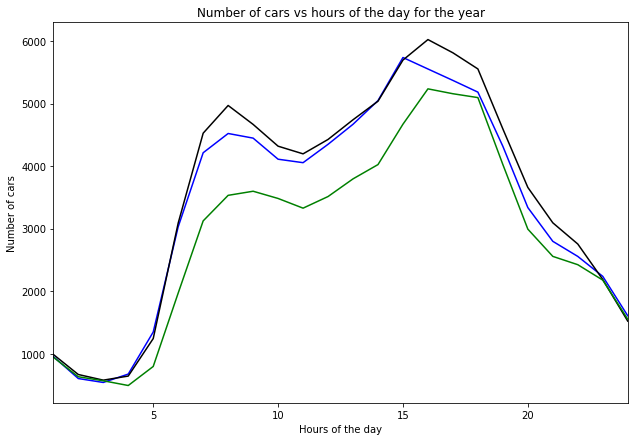

In [215]:

#Breaking up the traffic by station
sdtds_id_0 = sd_traffic_ds[sd_traffic_ds["station_id"] == station_ids[0]]
sdtds_id_1 = sd_traffic_ds[sd_traffic_ds["station_id"] == station_ids[1]]
sdtds_id_2 = sd_traffic_ds[sd_traffic_ds["station_id"] == station_ids[2]]

sdts_id_0_sum = sdtds_id_0.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"].sum()
sdts_id_1_sum = sdtds_id_1.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"].sum()
sdts_id_2_sum = sdtds_id_2.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"].sum()
sdtds_id_0_mean = np.mean(sdtds_id_0.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"])
sdtds_id_1_mean = np.mean(sdtds_id_1.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"])
sdtds_id_2_mean = np.mean(sdtds_id_2.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"])
sdtds_id_0_std = np.std(sdtds_id_0.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"])
sdtds_id_1_std = np.std(sdtds_id_1.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"])
sdtds_id_2_std = np.std(sdtds_id_2.loc[:,"traffic_volume_counted_after_0000_to_0100": \
               "traffic_volume_counted_after_2300_to_2400"])


#Plotting the most traffic by station 
plt.figure(1, figsize=(35, 7))
plt.subplot(131)
plt.title("Number of cars vs hours of the day for the year")
plt.xlabel("Hours of the day")
plt.ylabel("Number of cars")
plt.xlim((1,24))
plt.plot(range(1,25,1),sdtds_id_0_mean[0:],color = "blue")
plt.plot(range(1,25,1),sdtds_id_1_mean[0:],color = "black")
plt.plot(range(1,25,1),sdtds_id_2_mean[0:], color = "green")

#sdtds_0_mean_std = pd.DataFrame(sdtds_id_0_mean,sdtds_i)
#print(sdtds_id_0_mean, sdtds_id_0_std)

The above graph looks at a summation of the total amount of traffic through out the year. It appears that every station tends to see it's lower amount of traffic between 12:00am and 5:00am. 

Around 5:00am the traffic increases until 10pm and then fluctuates. Traffic gradually increases again around 5pm and then begins to slowly decrease. 

